# **Test**
This notebook is desired to test the pre-trained model with high-level testing informations.

---

### **Imports**

In [1]:
# metrics
from TumorDetector2.utils.metrics import apply_threshold,\
                                         overall_results
from sklearn.metrics import ConfusionMatrixDisplay,\
                            confusion_matrix

# graphs
import matplotlib.pyplot as plt

# data handler
from TumorDetector2.utils.data import _tfrecord_reader
from tensorflow.keras.models import model_from_json

import re

# system
from tensorflow._api.v2.config import list_physical_devices,\
                                      list_logical_devices,\
                                      set_visible_devices,\
                                      set_logical_device_configuration,\
                                      LogicalDeviceConfiguration
from tqdm import tqdm

import tensorflow as tf
import os

##### **Checking GPU**

In [2]:
# checking if GPU is available
gpus = list_physical_devices(device_type='GPU')
if gpus.__len__():
    set_visible_devices(devices=gpus[0], device_type='GPU')
    # limiting GPU memory
    set_logical_device_configuration(
        device=gpus[0],
        logical_devices=[
            LogicalDeviceConfiguration(memory_limit=3584) # limiting to 3.5GB
        ]
    )
    device = list_logical_devices(device_type='GPU')
    print('GPU has been detected: ' + str(device))
else:
    print('No GPU has been detected. The GPU acceleration is not enabled, it is EXTREMELLY recommended to use GPU for training.')

GPU has been detected: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


### **PARAMETERS**

In [3]:
MODEL_NAME = 'model_1'
DATA_TEST = None
THRESHOLD = 0.5

### **Loading Pre-Trained Model**

In [4]:
ARCHITECTURE_FILTER = r'([A-Za-z0-9_]+.json)'
MODEL_PATH = os.path.join('../weights', MODEL_NAME)
WEIGHTS_PATH = os.path.join(MODEL_PATH, 'checkpoints.h5')

# checking if model exist
if os.path.exists(MODEL_PATH):
    # reading parameters file
    with open(os.path.join(MODEL_PATH, 'parameters.txt'), 'r') as parameters:
        config = re.search(
            ARCHITECTURE_FILTER,
            parameters.read()
        ).group(0)
    config_path = os.path.join('../models', config)
    # loading architecture
    if os.path.exists(config_path):
        with open(config_path, 'r') as architecture:
            MODEL = model_from_json(architecture.read())
        # loading weights
        if os.path.exists(WEIGHTS_PATH):
            MODEL.load_weights(filepath=WEIGHTS_PATH)
        else:
            raise FileExistsError(f'There is no weights for this model.')
    else:
        raise FileExistsError(f'There is no architecture called {config}.')
else:
    raise FileExistsError(f'There is no pre-trained model called {MODEL_NAME}.')

### **Loading Test Data**

In [5]:
# loading data test
if DATA_TEST is None:
    TEST = tf.data.TFRecordDataset(filenames=os.path.join('../data', 'test.tfrecord')).map(_tfrecord_reader).batch(1).shuffle(True)

### **Testing**

##### **Running Inferences**

Running inference in test dataset: 55it [00:05, 10.37it/s]


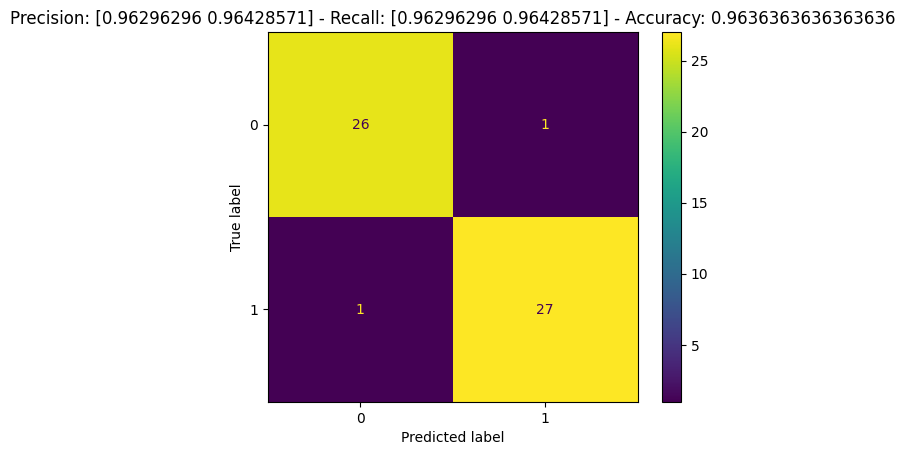

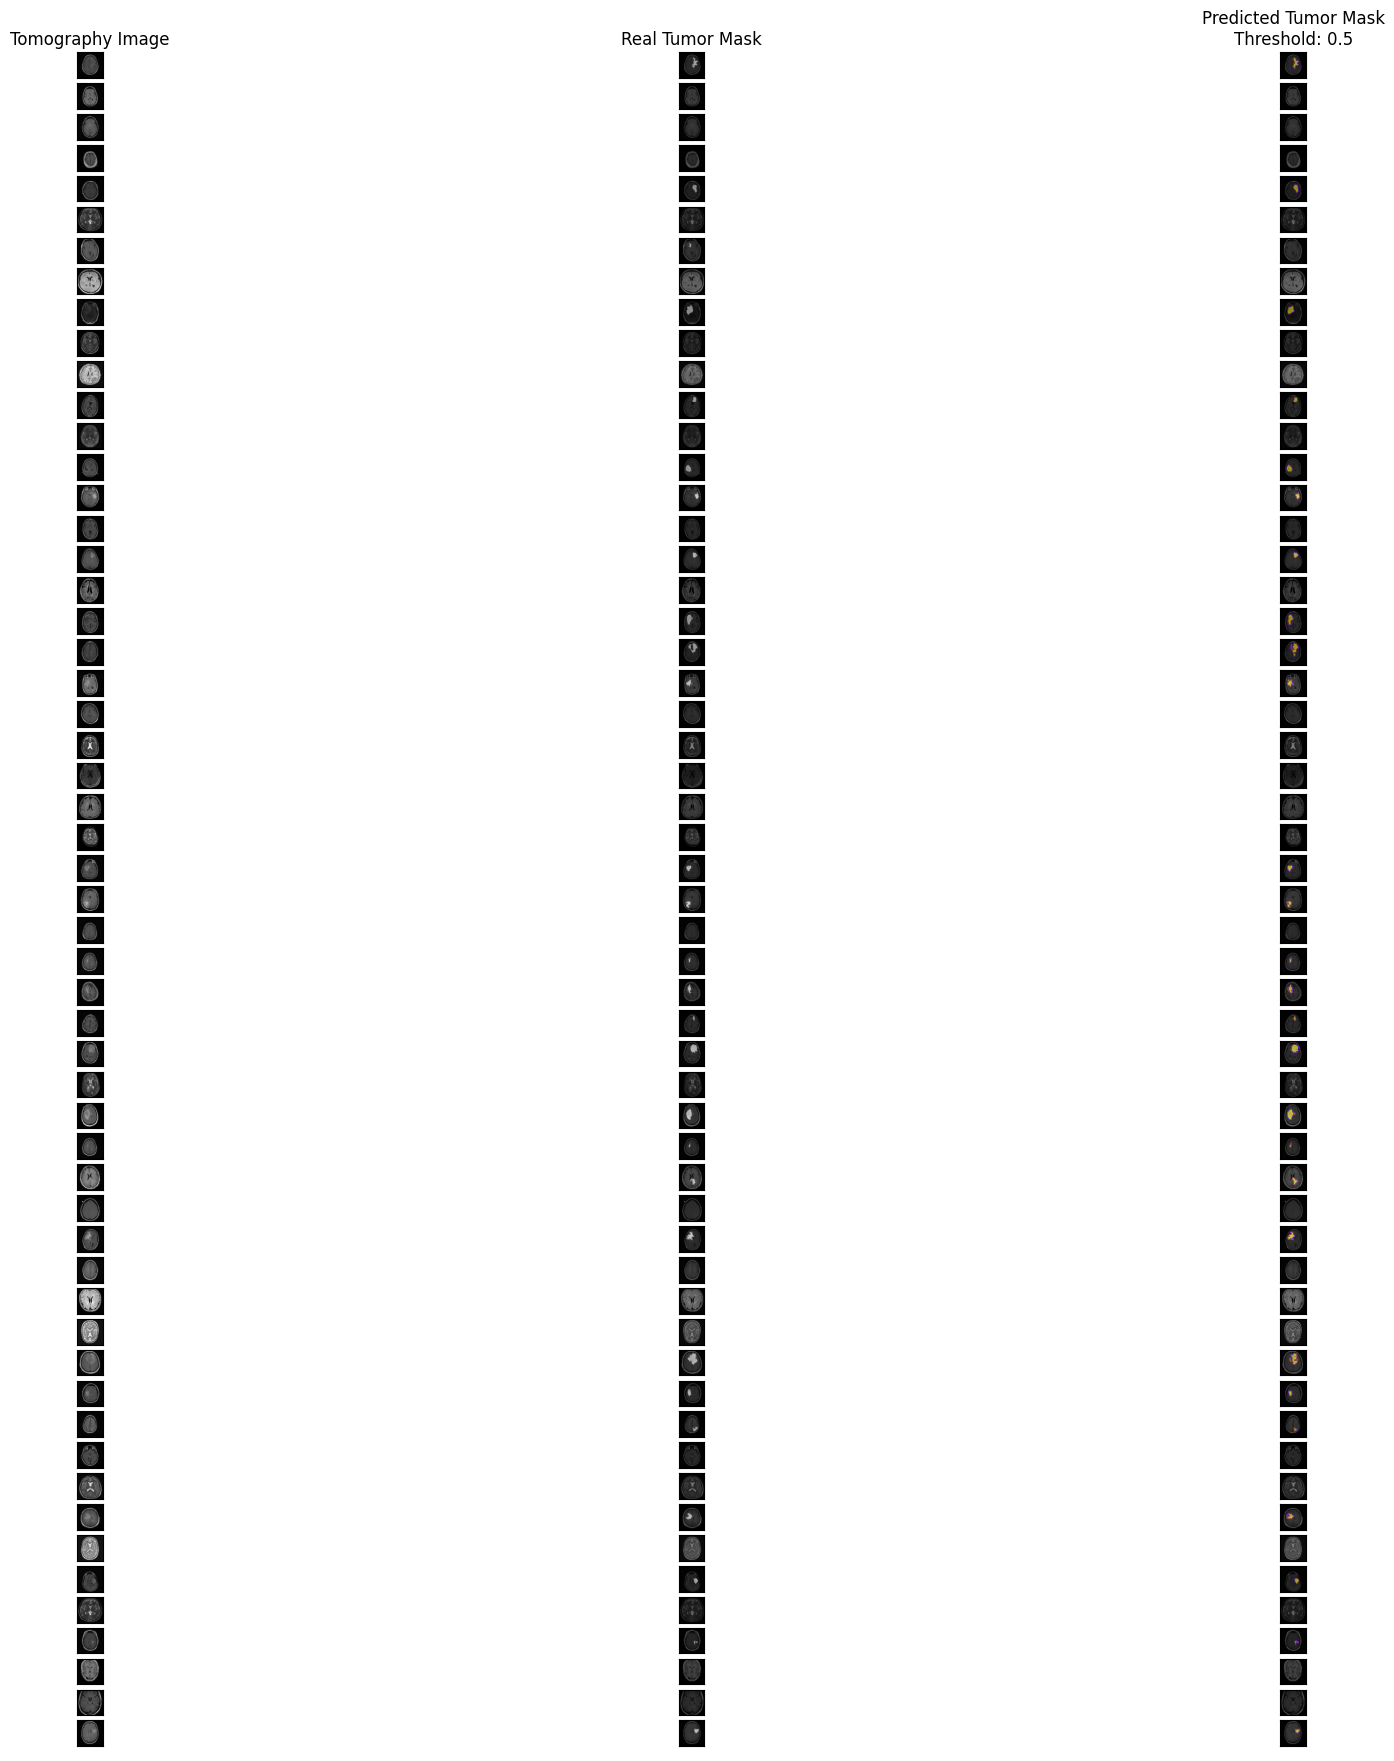

In [24]:
PREDICT_MASKS = []
PREDICT_LABELS = []
LABELS = []
IMAGES = []
MASKS = []

if DATA_TEST is None:
    for image, mask, label in tqdm(iterable=TEST, desc='Running inference in test dataset'):
        
        # predicting mask
        predict = MODEL(image, training=False)
        
        # applying threshold
        predict = apply_threshold(predict, THRESHOLD)[0][:,:,0].numpy()
        
        # saving images
        IMAGES.append(image[0][:,:,0].numpy())
        MASKS.append(mask[0][:,:,0].numpy())
        LABELS.append(label.numpy()[0])
        PREDICT_MASKS.append(predict)
        
        if predict.sum():
            PREDICT_LABELS.append(1)
        else:
            PREDICT_LABELS.append(0)
        
    # calulating scores
    ACCURACY, RECALLS, PRECISIONS = overall_results(LABELS, PREDICT_LABELS)
    
    cm = confusion_matrix(LABELS, PREDICT_LABELS)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    cmd.plot()
    cmd.ax_.set_title(f'Precision: {PRECISIONS} - Recall: {RECALLS} - Accuracy: {ACCURACY}')

    # displaying predicted mask
    fig, ax = plt.subplots(nrows=IMAGES.__len__(), ncols=3, figsize=(22,22))
    
    for index, txt in enumerate(['Tomography Image', 'Real Tumor Mask', f'Predicted Tumor Mask\nThreshold: {THRESHOLD}']):
        ax[0][index].set_title(txt, fontsize=12)
    
    for index, (image, mask, predict) in enumerate(zip(IMAGES, MASKS, PREDICT_MASKS)):
        
        # image
        ax[index][0].imshow(image, cmap='gray')
        
        # mask
        ax[index][1].imshow(image, cmap='gray')
        ax[index][1].imshow(mask, cmap='gray', alpha=0.45)
        
        # predict
        ax[index][2].imshow(image, cmap='gray')
        ax[index][2].imshow(predict, cmap='gnuplot', alpha=0.45)
        
        for j in range(3):
            ax[index][j].get_xaxis().set_visible(False)
            ax[index][j].get_yaxis().set_visible(False)
    
    plt.show()